# Data science in practice - Project, MGT-415, 11.05.2020
### Aubry Yannick, Fontannaz Benoît, Muret Gabriel Pierre Etienne, Tedeschi Julien Brian, Terrier Cédric

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from math import sqrt
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model


# Data importation, cleaning and analysis
The first step is the importation of the data in order to prepare it for the algorithm. Then the features are listed and explored. The dataset contains information about house sales in the small city of Ames in Iowa.

In [2]:
data = pd.read_csv('train.csv')
for name,dtype in zip(data.columns, data.dtypes):
    print(name,": ", dtype, "         Ex: ", data[name].iloc[0], "    Number of NaN: ", data[name].isnull().sum())

Id :  int64          Ex:  1     Number of NaN:  0
MSSubClass :  int64          Ex:  60     Number of NaN:  0
MSZoning :  object          Ex:  RL     Number of NaN:  0
LotFrontage :  float64          Ex:  65.0     Number of NaN:  259
LotArea :  int64          Ex:  8450     Number of NaN:  0
Street :  object          Ex:  Pave     Number of NaN:  0
Alley :  object          Ex:  nan     Number of NaN:  1369
LotShape :  object          Ex:  Reg     Number of NaN:  0
LandContour :  object          Ex:  Lvl     Number of NaN:  0
Utilities :  object          Ex:  AllPub     Number of NaN:  0
LotConfig :  object          Ex:  Inside     Number of NaN:  0
LandSlope :  object          Ex:  Gtl     Number of NaN:  0
Neighborhood :  object          Ex:  CollgCr     Number of NaN:  0
Condition1 :  object          Ex:  Norm     Number of NaN:  0
Condition2 :  object          Ex:  Norm     Number of NaN:  0
BldgType :  object          Ex:  1Fam     Number of NaN:  0
HouseStyle :  object          Ex: 

To have a better understanding of the real estate market in Ames a general overview of the dataset is required. Some information like the price distribution, the location or the types of houses are helpfull.

In [3]:
data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [4]:
data.describe(include=['O'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [5]:
for column in data:
    print(data[column].value_counts())

1460    1
479     1
481     1
482     1
483     1
       ..
976     1
977     1
978     1
979     1
1       1
Name: Id, Length: 1460, dtype: int64
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
        ... 
106.0      1
38.0       1
138.0      1
140.0      1
137.0      1
Name: LotFrontage, Length: 110, dtype: int64
7200     25
9600     24
6000     17
10800    14
9000     14
         ..
7094      1
6130      1
9337      1
5232      1
8190      1
Name: LotArea, Length: 1073, dtype: int64
Pave    1454
Grvl       6
Name: Street, dtype: int64
Grvl    50
Pave    41
Name: Alley, dtype: int64
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
Lvl    1311


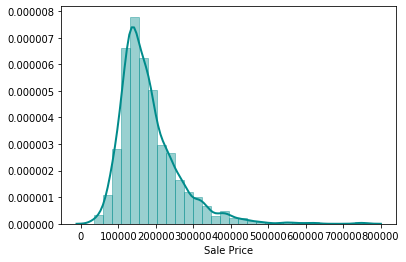

In [6]:
sns.distplot(data["SalePrice"], hist=True, kde=True, 
             bins=int(30), color = "darkcyan", 
             hist_kws={'edgecolor':'darkcyan'},
             kde_kws={'linewidth': 2})

plt.xlabel('Sale Price')

plt.savefig('PriceDistribution.png')

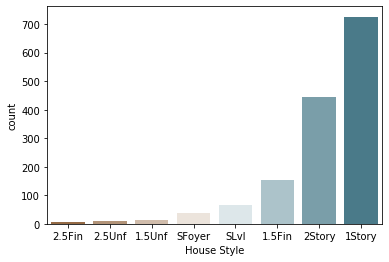

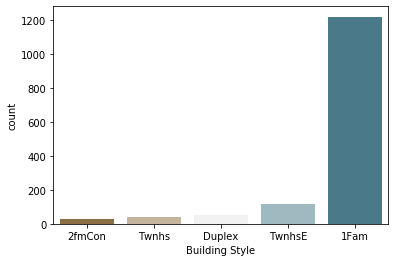

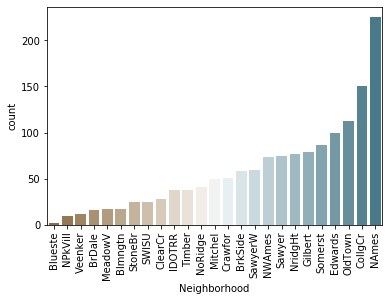

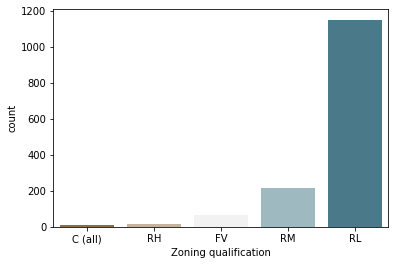

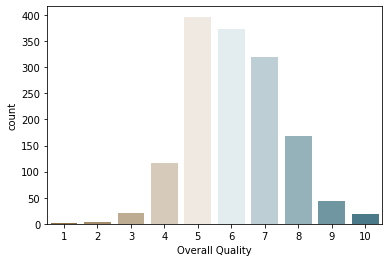

In [7]:
ax = sns.countplot(x="HouseStyle", data=data, order=data["HouseStyle"].value_counts().sort_values().index, palette = sns.diverging_palette(40, 220, n=8)) #comment changer la taille
plt.xlabel('House Style')
plt.savefig('HoustyleCount.png', bbox_inches='tight')
plt.show()


ax = sns.countplot(x="BldgType", data=data, order=data["BldgType"].value_counts().sort_values().index, palette = sns.diverging_palette(410, 220, n=5)) #comment changer la taille
plt.xlabel('Building Style')
plt.savefig('BldgTypeCount.png', bbox_inches='tight')
plt.show()


ax = sns.countplot(x="Neighborhood", data=data, order=data["Neighborhood"].value_counts().sort_values().index, palette = sns.diverging_palette(410, 220, n=25)) #comment changer la taille
plt.xticks(rotation=90)
plt.xlabel('Neighborhood')
plt.savefig('NeighborhoodCount.png', bbox_inches='tight')
plt.show()

ax = sns.countplot(x="MSZoning", data=data, order=data["MSZoning"].value_counts().sort_values().index,palette =sns.diverging_palette(410, 220, n=5)) 
plt.xlabel('Zoning qualification')
plt.savefig('Zoning.png', bbox_inches='tight')
plt.show()

ax = sns.countplot(x="OverallQual", data=data, palette =sns.diverging_palette(410, 220, n=10)) 
plt.xlabel('Overall Quality')
plt.savefig('OverallQualCount.png', bbox_inches='tight')
plt.show()


# Data Cleaning
Given this analysis, we can notice that some features do not contain any valuable information, for example the ID column. For this reason the ID column will be droped from the data set

In addition of that, we notice that there is many missing values. The job here would be to differanciate missing values (errors in the dataset) from the absence of the concernate feature in the house.

In the first case some columns have a high amount of missing values and might be related to other column that are more complete. The columns with a significant amount of missing values are:

- LotFrontage: 259 NaN
- Alley: 1369 NaN
- FireplaceQu: 690 NaN
- PoolQC: 1453 NaN
- Fence: 1179 NaN
- MiscFeature: 1406 NaN

For LotFrontage, since there is difficult to have no frontage we assumed that the NaN values can be replaced by the median. For PoolQC and MiscFeature that have above 95% of missing values and taken into account that the features PoolArea and MiscVal were complete, it was possible to remowe the features. In the case of the others the NaN values were set to 0 since it is probable that they the houses do not have this feature.

For the same reason, all the lower missing value number were also set to 0.

In [8]:
#To many Nan and similar information is already contained in another column
data_cleaned=data.drop(columns=["Id","PoolQC","MiscFeature"] )  

data_cleaned['LotFrontage'] = data_cleaned['LotFrontage'].fillna(data_cleaned['LotFrontage'].median()) #Nan are replaced by the median 
data_cleaned['Alley'] = data_cleaned['Alley'].fillna(0) # there is no alley. Nan is set to 0
data_cleaned['MasVnrType'] = data_cleaned['MasVnrType'].fillna('None') # Object type fill Na with None
data_cleaned['MasVnrArea'] = data_cleaned['MasVnrArea'].fillna(0) # No Vnr so Area=0


# House has no basement
data_cleaned['BsmtQual'] = data_cleaned['BsmtQual'].fillna(0)
data_cleaned['BsmtCond'] = data_cleaned['BsmtCond'].fillna(0)
data_cleaned['BsmtExposure'] = data_cleaned['BsmtExposure'].fillna(0)
data_cleaned['BsmtFinType1'] = data_cleaned['BsmtFinType1'].fillna(0)
data_cleaned['BsmtFinType2'] = data_cleaned['BsmtFinType2'].fillna(0)
data_cleaned['BsmtCond'] = data_cleaned['BsmtCond'].fillna(0)


data_cleaned['Electrical'] = data_cleaned['Electrical'].fillna(0) # One house has no electricity

data_cleaned['FireplaceQu'] = data_cleaned['FireplaceQu'].fillna(0) # some house don't have a fire place

# these houses don't have a garage
data_cleaned['GarageType'] = data_cleaned['GarageType'].fillna(0)  
data_cleaned['GarageYrBlt'] = data_cleaned['GarageYrBlt'].fillna(0) 
data_cleaned['GarageFinish'] = data_cleaned['GarageFinish'].fillna(0) 
data_cleaned['GarageQual'] = data_cleaned['GarageQual'].fillna(0) 
data_cleaned['GarageCond'] = data_cleaned['GarageCond'].fillna(0) 

data_cleaned['Fence'] = data_cleaned['Fence'].fillna(0) #no fence

for name,dtype in zip(data_cleaned.columns, data_cleaned.dtypes):
    print(name,": ", dtype, "         Ex: ", data_cleaned[name].iloc[0], "    Number of NaN: ", data_cleaned[name].isnull().sum())

MSSubClass :  int64          Ex:  60     Number of NaN:  0
MSZoning :  object          Ex:  RL     Number of NaN:  0
LotFrontage :  float64          Ex:  65.0     Number of NaN:  0
LotArea :  int64          Ex:  8450     Number of NaN:  0
Street :  object          Ex:  Pave     Number of NaN:  0
Alley :  object          Ex:  0     Number of NaN:  0
LotShape :  object          Ex:  Reg     Number of NaN:  0
LandContour :  object          Ex:  Lvl     Number of NaN:  0
Utilities :  object          Ex:  AllPub     Number of NaN:  0
LotConfig :  object          Ex:  Inside     Number of NaN:  0
LandSlope :  object          Ex:  Gtl     Number of NaN:  0
Neighborhood :  object          Ex:  CollgCr     Number of NaN:  0
Condition1 :  object          Ex:  Norm     Number of NaN:  0
Condition2 :  object          Ex:  Norm     Number of NaN:  0
BldgType :  object          Ex:  1Fam     Number of NaN:  0
HouseStyle :  object          Ex:  2Story     Number of NaN:  0
OverallQual :  int64       

In the following, we convert all the objects into integers. For the quality feature the ranking is respected, a high score represents a high quality.


In [9]:
data_cleaned['MSZoning'] = data_cleaned['MSZoning'].replace("C (all)", 0).replace("RH", 1).replace("RM", 2).replace("RL", 3).replace("FV", 4)
data_cleaned['Street'] = data_cleaned['Street'].replace("Grvl", 1).replace("Pave", 2)
data_cleaned['Alley'] = data_cleaned['Alley'].replace("Grvl", 1).replace("Pave", 2)
data_cleaned['LotShape'] = data_cleaned['LotShape'].replace("Reg", 0).replace("IR1", 1).replace("IR2", 2).replace("IR3", 3) #retrouver le petit quartier pour adapter les codes
data_cleaned['LandContour'] = data_cleaned['LandContour'].replace("Low", 0).replace("HLS", 1).replace("Bnk", 2).replace("Lvl", 3) #A voir si les valeur ont du sens

data_cleaned['Utilities'] = data_cleaned['Utilities'].replace("NoSeWa", 0).replace("AllPub", 1)
data_cleaned['LotConfig'] = data_cleaned['LotConfig'].replace("Inside", 0).replace("Corner", 1).replace("FR2", 2).replace("FR3", 3).replace("CulDSac", 4)
data_cleaned['LandSlope'] = data_cleaned['LandSlope'].replace("Sev", 0).replace("Mod", 1).replace("Gtl", 2)
data_cleaned['Neighborhood'] = data_cleaned['Neighborhood'].replace("NAmes", 0).replace("CollgCr",1).replace("OldTown",2).replace("Edwards",3).replace("Somerst", 4).replace("Gilbert", 5).replace("NridgHt", 6).replace("Sawyer", 7).replace("NWAmes",8).replace("SawyerW", 9).replace("BrkSide",10).replace("Crawfor",11).replace("Mitchel",12).replace("NoRidge", 13).replace("Timber", 14).replace("IDOTRR", 15).replace("ClearCr",16).replace("SWISU", 17).replace("StoneBr", 18).replace("Blmngtn", 19).replace("MeadowV", 20).replace("BrDale", 21).replace("Veenker", 22).replace("NPkVill", 23).replace("Blueste", 24)
data_cleaned['Condition1'] = data_cleaned['Condition1'].replace("Norm", 0).replace("Feedr", 1).replace("Artery", 2).replace("RRAn", 3).replace("PosN", 4).replace("RRAe", 5).replace("PosA", 6).replace("RRNn", 7).replace("RRNe", 8)

data_cleaned['Condition2'] = data_cleaned['Condition2'].replace("Norm", 0).replace("Feedr", 1).replace("Artery", 2).replace("RRAn", 3).replace("PosN", 4).replace("RRAe", 5).replace("PosA", 6).replace("RRNn", 7).replace("RRNe", 8)
data_cleaned['BldgType'] = data_cleaned['BldgType'].replace("1Fam", 0).replace("TwnhsE", 1).replace("Duplex", 2).replace("Twnhs", 3).replace("2fmCon", 4)
data_cleaned['HouseStyle'] = data_cleaned['HouseStyle'].replace("1Story", 0).replace("2Story", 1).replace("1.5Fin", 2).replace("SLvl", 3).replace("SFoyer", 4).replace("1.5Unf", 5).replace("2.5Unf", 6).replace("2.5Fin", 7)
data_cleaned['RoofStyle'] = data_cleaned['RoofStyle'].replace("Gable", 0).replace("Hip", 1).replace("Flat", 2).replace("Gambrel", 3).replace("Mansard", 4).replace("Shed", 5)
data_cleaned['RoofMatl'] = data_cleaned['RoofMatl'].replace("CompShg", 0).replace("Tar&Grv", 1).replace("MetalSd", 2).replace("WdShngl", 3).replace("WdShake", 4).replace("ClyTile",6).replace("Membran", 6).replace("Roll", 7).replace("Metal", 8)

data_cleaned['Exterior1st'] = data_cleaned['Exterior1st'].replace("VinylSd", 0).replace("HdBoard", 1).replace("MetalSd", 2).replace("Wd Sdng", 3).replace("Plywood", 4).replace("CemntBd",5).replace("BrkFace", 6).replace("WdShing", 7).replace("Stucco", 8).replace("AsbShng", 9).replace("Stone",10).replace("BrkComm", 11).replace("CBlock", 12).replace("ImStucc", 13).replace("AsphShn", 14)
data_cleaned['Exterior2nd'] = data_cleaned['Exterior2nd'].replace("VinylSd", 0).replace("HdBoard", 1).replace("MetalSd", 2).replace("Wd Sdng", 3).replace("Plywood", 4).replace("CemntBd",5).replace("BrkFace", 6).replace("Wd Shng", 7).replace("Stucco", 8).replace("AsbShng", 9).replace("Stone",10).replace("BrkComm", 11).replace("CBlock", 12).replace("ImStucc", 13).replace("AsphShn", 14).replace("CmentBd", 15).replace("Wd Shbg", 16).replace("Brk Cmn", 17).replace("Other", 18)
data_cleaned['MasVnrType'] = data_cleaned["MasVnrType"].replace("None", 0).replace("BrkFace", 1).replace("Stone", 2).replace("BrkCmn", 3) #Classer
data_cleaned['ExterQual'] = data_cleaned['ExterQual'].replace("Po", 1).replace("Fa", 2).replace("TA", 3).replace("Gd", 4).replace("Ex", 5)
data_cleaned['ExterCond'] = data_cleaned['ExterQual'].replace("Po", 1).replace("Fa", 2).replace("TA", 3).replace("Gd", 4).replace("Ex", 5)

data_cleaned['Foundation'] = data_cleaned['Foundation'].replace("PConc", 0).replace("CBlock", 1).replace("BrkTil", 2).replace("Slab", 3).replace("Stone", 4).replace("Wood",5) #A adapter Ordre décroissant
data_cleaned['BsmtQual'] = data_cleaned['BsmtQual'].replace("Po", 1).replace("Fa", 2).replace("TA", 3).replace("Gd", 4).replace("Ex", 5) #Droper NA et classer dans l'ordre 
data_cleaned['BsmtCond'] = data_cleaned['BsmtCond'].replace("Po", 1).replace("Fa", 2).replace("TA", 3).replace("Gd", 4).replace("Ex", 5) # la même jusqu'à Total jusqu'au heat
data_cleaned['BsmtExposure'] = data_cleaned['BsmtExposure'].replace("No", 1).replace("Mn", 2).replace("Av", 3).replace("Gd", 4)
data_cleaned['BsmtFinType1'] = data_cleaned['BsmtFinType1'].replace("Unf", 1).replace("LwQ", 2).replace("Rec", 3).replace("BLQ", 4).replace("ALQ", 5).replace("GLQ", 6)

data_cleaned['BsmtFinType2'] = data_cleaned['BsmtFinType2'].replace("Unf", 1).replace("LwQ", 2).replace("Rec", 3).replace("BLQ", 4).replace("ALQ", 5).replace("GLQ", 6)
data_cleaned['Heating'] = data_cleaned['Heating'].replace("Wall", 1).replace("OthW", 2).replace("Grav", 3).replace("GasW", 4).replace("GasA", 5).replace("Floor", 6) #Chaufage au sol meilleur et 0 si pas de chauffage
data_cleaned['HeatingQC'] = data_cleaned['HeatingQC'].replace("Po", 1).replace("Fa", 2).replace("TA", 3).replace("Gd", 4).replace("Ex", 5)
data_cleaned['CentralAir'] = data_cleaned['CentralAir'].replace("Y", 1).replace("N", 0)
data_cleaned['Electrical'] = data_cleaned['Electrical'].replace("SBrkr", 1).replace("FuseA", 2).replace("FuseF", 3).replace("FuseP", 4).replace("Mix", 5) 

data_cleaned['KitchenQual'] = data_cleaned['KitchenQual'].replace("Po", 1).replace("Fa", 2).replace("TA", 3).replace("Gd", 4).replace("Ex", 5) 
data_cleaned['Functional'] = data_cleaned['Functional'].replace("Typ", 0).replace("Min2", 1).replace("Min1", 2).replace("Mod", 3).replace("Maj1", 4).replace("Maj2", 5).replace("Sev",6)
data_cleaned['FireplaceQu'] = data_cleaned['FireplaceQu'].replace("Po", 1).replace("Fa", 2).replace("TA", 3).replace("Gd", 4).replace("Ex", 5)
data_cleaned['GarageType'] = data_cleaned['GarageType'].replace("Attchd", 1).replace("Detchd", 2).replace("BuiltIn", 3).replace("Basment", 4).replace("CarPort", 5).replace("2Types", 6) 
data_cleaned['GarageFinish'] = data_cleaned['GarageFinish'].replace("Unf", 1).replace("RFn", 2).replace("Fin", 3)

data_cleaned['GarageQual'] = data_cleaned['GarageQual'].replace("Po", 1).replace("Fa", 2).replace("TA", 3).replace("Gd", 4).replace("Ex", 5)
data_cleaned['GarageCond'] = data_cleaned['GarageCond'].replace("Po", 1).replace("Fa", 2).replace("TA", 3).replace("Gd", 4).replace("Ex", 5)
data_cleaned['PavedDrive'] = data_cleaned['PavedDrive'].replace("N", 0).replace("P", 1).replace("Y", 2) 
data_cleaned['Fence'] = data_cleaned['Fence'].replace("MnWw", 1).replace("GdWo", 2).replace("MnPrv", 3).replace("GdPrv", 4) 

data_cleaned['SaleType'] = data_cleaned['SaleType'].replace("WD", 0).replace("New", 1).replace("COD", 2).replace("ConLD", 3).replace("ConLw", 4).replace("ConLI", 5).replace("CWD", 6).replace("Oth", 7).replace("Con",8)
data_cleaned['SaleCondition'] = data_cleaned['SaleCondition'].replace("Normal", 0).replace("Partial",1).replace("Abnorml", 2).replace("Family", 3).replace("Alloca", 4).replace("AdjLand", 5)

In [10]:
# check that no object and no Nan is remaining
for name,dtype in zip(data_cleaned.columns, data_cleaned.dtypes):
    print(name,": ", dtype, "         Ex: ", data_cleaned[name].iloc[0], "    Number of NaN: ", data_cleaned[name].isnull().sum())

for column in data_cleaned:
    print("---------------\n", data_cleaned[column].value_counts())

MSSubClass :  int64          Ex:  60     Number of NaN:  0
MSZoning :  int64          Ex:  3     Number of NaN:  0
LotFrontage :  float64          Ex:  65.0     Number of NaN:  0
LotArea :  int64          Ex:  8450     Number of NaN:  0
Street :  int64          Ex:  2     Number of NaN:  0
Alley :  int64          Ex:  0     Number of NaN:  0
LotShape :  int64          Ex:  0     Number of NaN:  0
LandContour :  int64          Ex:  3     Number of NaN:  0
Utilities :  int64          Ex:  1     Number of NaN:  0
LotConfig :  int64          Ex:  0     Number of NaN:  0
LandSlope :  int64          Ex:  2     Number of NaN:  0
Neighborhood :  int64          Ex:  1     Number of NaN:  0
Condition1 :  int64          Ex:  0     Number of NaN:  0
Condition2 :  int64          Ex:  0     Number of NaN:  0
BldgType :  int64          Ex:  0     Number of NaN:  0
HouseStyle :  int64          Ex:  1     Number of NaN:  0
OverallQual :  int64          Ex:  7     Number of NaN:  0
OverallCond :  int64 

 0      1436
168       3
216       2
144       2
180       2
245       1
238       1
290       1
196       1
182       1
407       1
304       1
162       1
153       1
320       1
140       1
130       1
96        1
23        1
508       1
Name: 3SsnPorch, dtype: int64
---------------
 0      1344
192       6
224       5
120       5
189       4
       ... 
182       1
440       1
178       1
312       1
480       1
Name: ScreenPorch, Length: 76, dtype: int64
---------------
 0      1453
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64
---------------
 0    1179
3     157
4      59
2      54
1      11
Name: Fence, dtype: int64
---------------
 0        1408
400        11
500         8
700         5
450         4
2000        4
600         4
1200        2
480         2
1150        1
800         1
15500       1
620         1
3500        1
560         1
2500        1
1300        1
1400        1
350         1
8300        1
54  

In [11]:
print(data.shape)
print(data_cleaned.shape)
data_cleaned.describe()

(1460, 81)
(1460, 78)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,2.852740,69.863699,10516.828082,1.995890,0.090411,0.408219,2.814384,0.999315,0.510274,...,3.409589,15.060959,2.758904,0.565753,43.489041,6.321918,2007.815753,0.233562,0.311644,180921.195890
std,42.300571,0.527086,22.027677,9981.264932,0.063996,0.372151,0.582296,0.606509,0.026171,1.050750,...,29.317331,55.757415,40.177307,1.204483,496.123024,2.703626,1.328095,0.793805,0.767397,79442.502883
min,20.000000,0.000000,21.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000,0.000000,34900.000000
25%,20.000000,3.000000,60.000000,7553.500000,2.000000,0.000000,0.000000,3.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,0.000000,0.000000,129975.000000
50%,50.000000,3.000000,69.000000,9478.500000,2.000000,0.000000,0.000000,3.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,0.000000,0.000000,163000.000000
75%,70.000000,3.000000,79.000000,11601.500000,2.000000,0.000000,1.000000,3.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,0.000000,0.000000,214000.000000
max,190.000000,4.000000,313.000000,215245.000000,2.000000,2.000000,3.000000,3.000000,1.000000,4.000000,...,508.000000,480.000000,738.000000,4.000000,15500.000000,12.000000,2010.000000,8.000000,5.000000,755000.000000


# Data Exploration
Some features are more correlated with the sale price than others

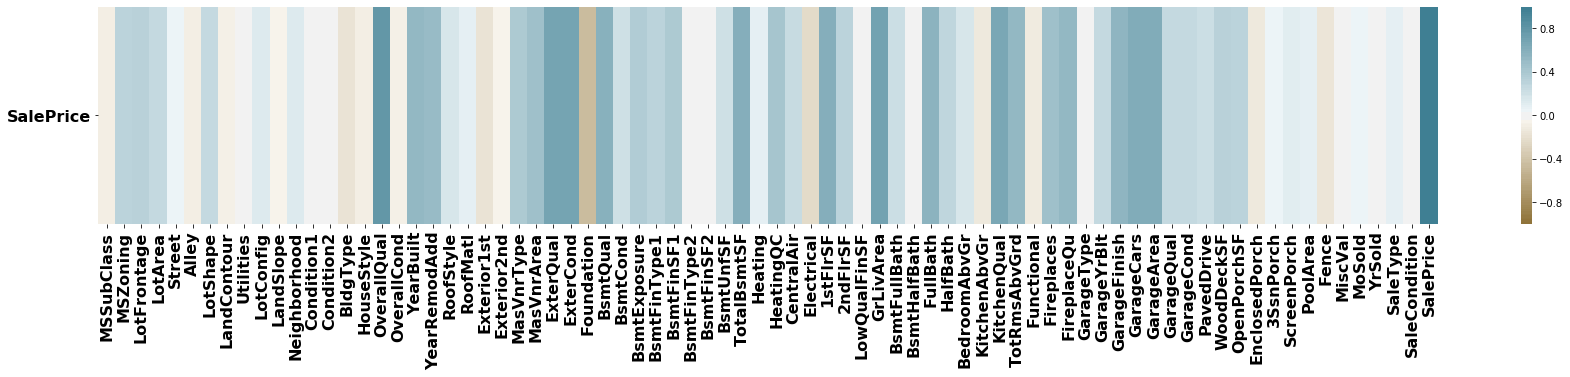

In [12]:
f,ax=plt.subplots(figsize=(30,4))
corr = data_cleaned.corr()
ax = sns.heatmap(corr.sort_values(by=['SalePrice'], ascending=False).head(1),
vmin=-1, vmax=1, center=0,
cmap=sns.diverging_palette(420, 220, n=100),
square=False)

plt.xticks(weight='bold', fontsize=16)
plt.yticks(weight='bold', rotation=0, fontsize=16)
plt.savefig('EDACorr.png',bbox_inches='tight')


In [13]:
corr = data_cleaned.corr()
corrVal=corr["SalePrice"].sort_values(ascending=False).to_frame()
corrVal.head(50)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
ExterCond,0.682639
ExterQual,0.682639
KitchenQual,0.659600
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852


Below are shown three examples of correlated variables and one example of non corrolated variable.

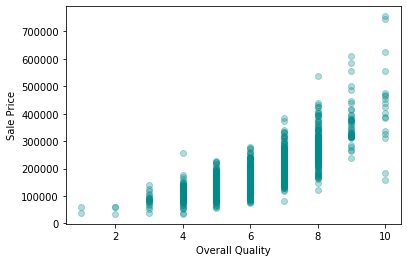

/Applications/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


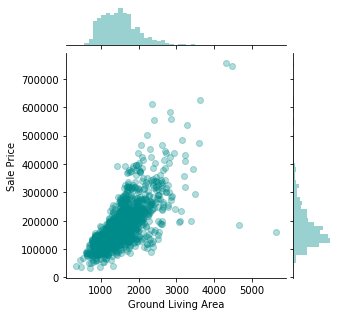

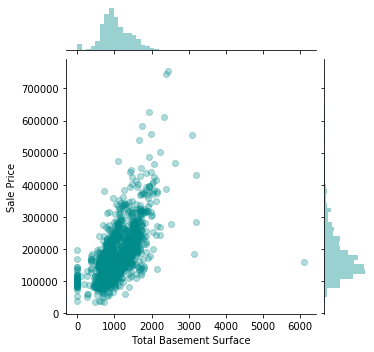

In [14]:
plt.scatter(data_cleaned["OverallQual"], data_cleaned["SalePrice"], color="darkcyan", alpha=0.3)
plt.xlabel('Overall Quality')
plt.ylabel('Sale Price')
plt.savefig('PriceOverallQual.png',bbox_inches='tight')
plt.show()


h=sns.jointplot(x=data_cleaned["GrLivArea"], y=data_cleaned["SalePrice"], color="darkcyan", alpha=0.3, size=4.5)
h.ax_joint.set_xlabel('Ground Living Area')
h.ax_joint.set_ylabel('Sale Price')
plt.savefig('PriceGrLivArea.png', bbox_inches='tight')

h=sns.jointplot(x=data_cleaned["TotalBsmtSF"], y=data_cleaned["SalePrice"], color="darkcyan", alpha=0.3, size=5)
h.ax_joint.set_xlabel('Total Basement Surface')
h.ax_joint.set_ylabel('Sale Price')
plt.savefig('PriceTotalBsmtSF.png',bbox_inches='tight')

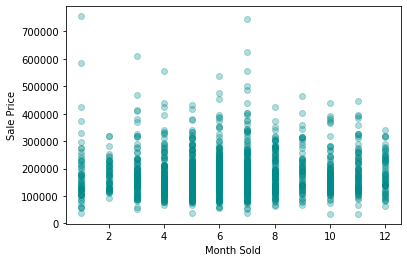

In [15]:
# no correlation example
plt.scatter(data_cleaned["MoSold"], data_cleaned["SalePrice"], c="darkcyan", alpha=0.3)
plt.xlabel('Month Sold')
plt.ylabel('Sale Price')
plt.savefig('PriceMoSold.png',bbox_inches='tight')
plt.show()


Even if neighborhood is also not really correlated with the saleprice, this information could be important for the business. It can indicate on which district we have to focus our business in order to make bigger profits. There could be some large differences of prices depending on the district.

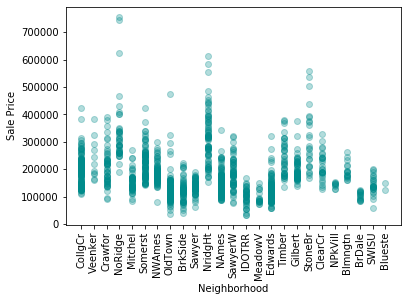

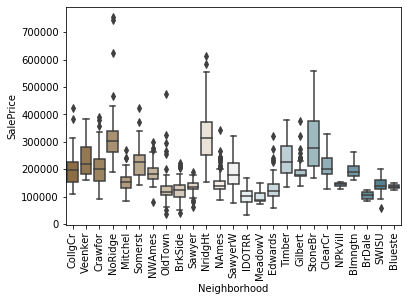

In [16]:
data_cleaned['Neighborhood'] = data_cleaned['Neighborhood'].replace(0,"NAmes").replace(1,"CollgCr").replace(2,"OldTown").replace(3,"Edwards").replace(4,"Somerst").replace(5,"Gilbert").replace(6,"NridgHt").replace(7,"Sawyer").replace(8,"NWAmes").replace(9,"SawyerW").replace(10,"BrkSide").replace(11,"Crawfor").replace(12,"Mitchel").replace(13,"NoRidge").replace(14,"Timber").replace(15,"IDOTRR").replace(16,"ClearCr").replace(17,"SWISU").replace(18,"StoneBr").replace(19,"Blmngtn").replace(20,"MeadowV").replace(21,"BrDale").replace(22,"Veenker").replace(23,"NPkVill").replace(24,"Blueste")

plt.scatter(data_cleaned["Neighborhood"], data_cleaned["SalePrice"], c="darkcyan", alpha=0.3)
plt.xlabel('Neighborhood')
plt.ylabel('Sale Price')
plt.xticks(rotation=90)
plt.savefig('PriceNeighborhood.png',bbox_inches='tight')
plt.show()


NeighborhoodMedian=data_cleaned.groupby('Neighborhood', as_index=False)["SalePrice"].median()
ax = sns.boxplot(x="Neighborhood", y="SalePrice", data=data_cleaned, palette = sns.diverging_palette(410, 220, n=25))
plt.xticks(rotation=90)
plt.savefig('PriceNeighborhoodBoxPlot.png',bbox_inches='tight')


data_cleaned['Neighborhood'] = data_cleaned['Neighborhood'].replace("NAmes", 0).replace("CollgCr",1).replace("OldTown",2).replace("Edwards",3).replace("Somerst", 4).replace("Gilbert", 5).replace("NridgHt", 6).replace("Sawyer", 7).replace("NWAmes",8).replace("SawyerW", 9).replace("BrkSide",10).replace("Crawfor",11).replace("Mitchel",12).replace("NoRidge", 13).replace("Timber", 14).replace("IDOTRR", 15).replace("ClearCr",16).replace("SWISU", 17).replace("StoneBr", 18).replace("Blmngtn", 19).replace("MeadowV", 20).replace("BrDale", 21).replace("Veenker", 22).replace("NPkVill", 23).replace("Blueste", 24)


In [17]:
NeighborhoodMedian.sort_values(by=['SalePrice'], ascending=False).head(30)

,Neighborhood,SalePrice
16,NridgHt,315000
15,NoRidge,301500
22,StoneBr,278000
23,Timber,228475
21,Somerst,225500
24,Veenker,218000
6,Crawfor,200624
4,ClearCr,200250
5,CollgCr,197200
0,Blmngtn,191000


Some variables are negatively correlated. They contain many valuable information too. 

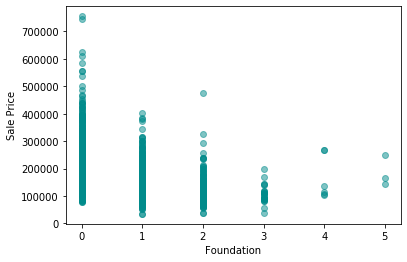

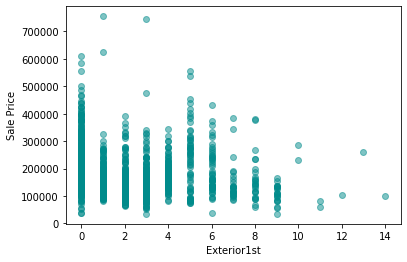

In [18]:
#other are negatively correlated which is also usefull
plt.scatter(data_cleaned["Foundation"], data_cleaned["SalePrice"], c="darkcyan", alpha=0.5)
plt.ylabel('Sale Price')
plt.xlabel('Foundation')
plt.savefig('PriceFoundation.png',bbox_inches='tight')
plt.show()


plt.scatter(data_cleaned["Exterior1st"], data_cleaned["SalePrice"], c="darkcyan", alpha=0.5)
plt.ylabel('Sale Price')
plt.xlabel('Exterior1st')
plt.savefig('PriceExterior1st.png',bbox_inches='tight')
plt.show()

# Outliers removing
From the previous graphs some scatter points could be identified as outliers. They are removed using the DBSCAN function.

In [19]:
X = StandardScaler().fit_transform(data_cleaned.values)

db = DBSCAN(eps=12.0, min_samples=10).fit(X)
labels = db.labels_

print(pd.Series(labels).value_counts())
data_cleaned["Outliers"]=labels
data_cleaned = data_cleaned[data_cleaned.Outliers != -1]
data_cleaned=data_cleaned.drop(columns=["Outliers"] )

 0    1418
-1      42
dtype: int64


# Feature engineering

The purpose of this section is to boost the performances of the algorithm by implementing new feature highly corrolated with the sale price. The feature engineering allows us to used more efficiently our variables by adding four new variables. 

,SalePrice
SalePrice,1.000000
CorrQual,0.772110
AreaPerKitchen,0.764258
AreaPerRoom,0.535075
BathOverArea,0.027608
BathOverAreaWithBsmt,-0.003298
BedroomOverArea,-0.559298


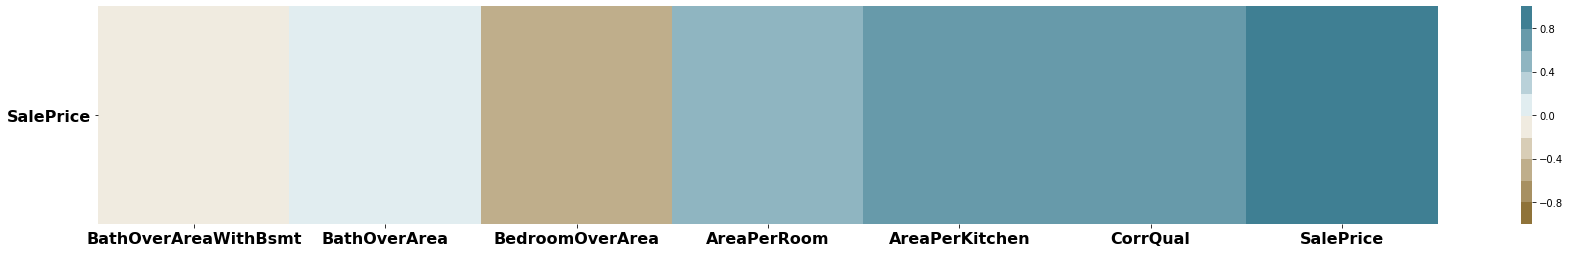

In [20]:
#new features
data_cleaned["BathOverAreaWithBsmt"]=(data_cleaned["BsmtFullBath"]+data_cleaned["BsmtHalfBath"]+data_cleaned["FullBath"]+data_cleaned["HalfBath"])/(data_cleaned["TotalBsmtSF"]+data_cleaned["GrLivArea"])
data_cleaned["BathOverArea"]=(data_cleaned["FullBath"]+data_cleaned["HalfBath"])/(data_cleaned["GrLivArea"])
data_cleaned["BedroomOverArea"]=(data_cleaned["BedroomAbvGr"]/data_cleaned["GrLivArea"])
data_cleaned["AreaPerKitchen"]=1/(data_cleaned["KitchenAbvGr"]/data_cleaned["GrLivArea"])
data_cleaned["AreaPerRoom"]=1/(data_cleaned["TotRmsAbvGrd"]/data_cleaned["GrLivArea"])
#Quality based feature with high correlation feature
data_cleaned["CorrQual"]=(data_cleaned["ExterCond"]+data_cleaned["ExterQual"]+data_cleaned["KitchenQual"]+data_cleaned["BsmtQual"]+data_cleaned["BsmtCond"]+data_cleaned["FireplaceQu"])/6


#correlation of the new features
New_data=data_cleaned[["BathOverAreaWithBsmt", "BathOverArea", "BedroomOverArea", "AreaPerRoom", "AreaPerKitchen","CorrQual","SalePrice"]]
New_data.head()
f,ax=plt.subplots(figsize=(30,4))
corr = New_data.corr()
ax = sns.heatmap(corr.sort_values(by=['SalePrice'], ascending=False).head(1),
vmin=-1, vmax=1, center=0,
cmap=sns.diverging_palette(420, 220, n=10),
square=False)

plt.xticks(weight='bold', fontsize=16)
plt.yticks(weight='bold', rotation=0, fontsize=16)
plt.savefig('CorrNewFeatures.png',bbox_inches='tight')


corrVal=corr["SalePrice"].sort_values(ascending=False).to_frame()
corrVal.head(8)

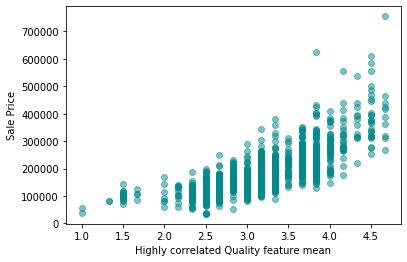

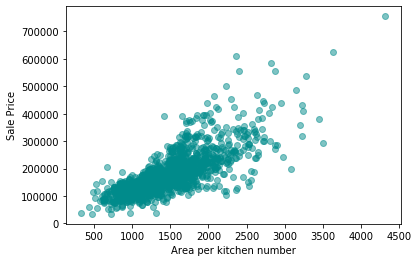

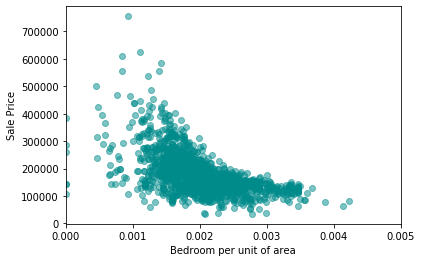

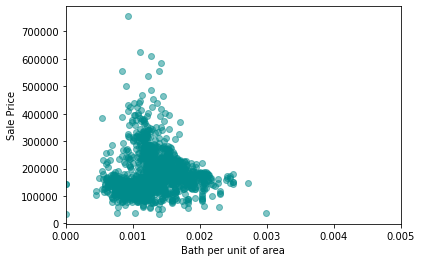

In [21]:
# example of plots of some new feature


# positive correlation
plt.scatter(data_cleaned["CorrQual"], data_cleaned["SalePrice"], c="darkcyan", alpha=0.5)
plt.ylabel('Sale Price')
plt.xlabel('Highly correlated Quality feature mean')
plt.savefig('PriceCorrQual.png',bbox_inches='tight')
plt.show()


plt.scatter(data_cleaned["AreaPerKitchen"], data_cleaned["SalePrice"], c="darkcyan", alpha=0.5)
plt.ylabel('Sale Price')
plt.xlabel('Area per kitchen number')
plt.savefig('PriceKitchenArea.png',bbox_inches='tight')
plt.show()


#negative correlation
plt.scatter(data_cleaned["BedroomOverArea"], data_cleaned["SalePrice"], c="darkcyan", alpha=0.5)
plt.ylabel('Sale Price')
plt.xlim(0, 0.005)
plt.xlabel('Bedroom per unit of area')
plt.savefig('PriceBedroomArea.png',bbox_inches='tight')
plt.show()


# no correlation
plt.scatter(data_cleaned["BathOverArea"], data_cleaned["SalePrice"], c="darkcyan", alpha=0.5)
plt.ylabel('Sale Price')
plt.xlim(0, 0.005)
plt.xlabel('Bath per unit of area')
plt.savefig('PriceBathArea.png',bbox_inches='tight')
plt.show()


In [22]:
# removing the non correlated new features
datSalePrice = data_cleaned['SalePrice']
data_cleaned = data_cleaned.drop(columns=["SalePrice"])
data_cleaned = data_cleaned.drop(columns=["BathOverArea","BathOverAreaWithBsmt"])
data_cleaned['SalePrice'] = datSalePrice
data_cleaned.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,BedroomOverArea,AreaPerKitchen,AreaPerRoom,CorrQual,SalePrice
0,60,3,65.0,8450,2,0,0,3,1,0,...,0,2,2008,0,0,0.001754,1710.0,213.750000,3.166667,208500
1,20,3,80.0,9600,2,0,0,3,1,2,...,0,5,2007,0,0,0.002377,1262.0,210.333333,3.166667,181500
2,60,3,68.0,11250,2,0,1,3,1,0,...,0,9,2008,0,0,0.001680,1786.0,297.666667,3.666667,223500
3,70,3,60.0,9550,2,0,1,3,1,1,...,0,2,2006,0,2,0.001747,1717.0,245.285714,3.500000,140000
4,60,3,84.0,14260,2,0,1,3,1,2,...,0,12,2008,0,0,0.001820,2198.0,244.222222,3.666667,250000


# Pre-Processing, Scaling and PCA

In [23]:
columns_X_train = data_cleaned.columns
print(columns_X_train)
x = data_cleaned.iloc[:, 0:len(data_cleaned.columns)-1].to_numpy()
y = data_cleaned['SalePrice'].to_numpy()


train_test_ratio = 0.2

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=train_test_ratio, random_state=42)
X_test_in = X_test
y_test_in = y_test

print("Train: ", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

To perform a PCA, the data should first be normalised. To do so, the data are scaled using their minimum and maximum values.
The dataset must be also divided in a train and test set.

In [24]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Then the PCA is done. The explained variance ratio provides the amount of variance explained by each dimensions of the problem. These dimensions do not have clear meanings in our problem. 80% of the sale price could be explained by only 22 dimensions instead of 77 given at the begining and 60 are enough to explain 99% of the variance.

In [25]:
pca = PCA()
pca.fit(X_train)
variance = np.cumsum(pca.explained_variance_ratio_)

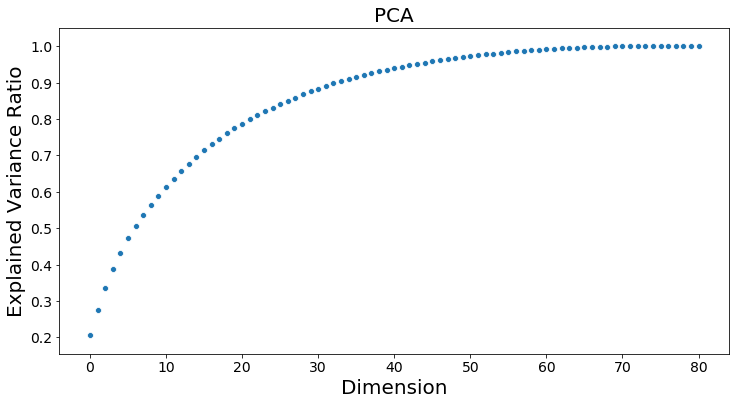

[0.20579874 0.27655534 0.33460995 0.38775151 0.43086607 0.47186256
 0.5064469  0.53599294 0.56322943 0.58919331 0.61290767 0.63549011
 0.65691751 0.67752102 0.69665478 0.71402772 0.73040502 0.74598397
 0.76067685 0.77428393 0.78697896 0.79891663 0.81029369 0.82101262
 0.8309592  0.84089709 0.8501183  0.85890082 0.86738326 0.87552669
 0.88327976 0.89089632 0.89754373 0.90365919 0.90943984 0.91512459
 0.92046618 0.92570403 0.93058538 0.93530019 0.93963571 0.94375861
 0.94768703 0.95133539 0.95482352 0.95817019 0.96143452 0.96448053
 0.96731034 0.96999571 0.97252231 0.97503577 0.97744108 0.9797317
 0.9818304  0.98386642 0.98575952 0.98745478 0.98900235 0.99043448]


In [26]:
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(data=variance)
ax.set_xlabel('Dimension', fontsize = 20)
ax.set_ylabel('Explained Variance Ratio', fontsize = 20)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.title("PCA", fontsize = 20)
plt.show()
print(variance[0:60])

In [27]:
pca = PCA(n_components=70)
pca.fit(X_train)
train_input = X_train
test_input = X_test

In the following, three functions are built. The first one is used for the cross validation. It splits a dataset n times. The second function predict the price of a random set of n houses once the learning process on the train set has been done. The last function do the same as the second function but it takes the n first houses of the test set.

In [28]:
# Train folding (cross-val)
n = 6
cv = ShuffleSplit(n_splits=n, test_size=0.3, random_state=0)
print(cv)

ShuffleSplit(n_splits=6, random_state=0, test_size=0.3, train_size=None)


In [29]:
# Random sklearn prediction function
def random_prediction(x: np.ndarray, reg, n=5):
    size = x.shape[0]-1
    for _ in range(n):
        number = random.randint(0, size)
        y = y_test[number]
        y_hat = int(reg.predict(test_input[number].reshape(1, -1))[0])
        print(y_hat)
        print("Real price: ", y, " Predicted one: ", y_hat, " Error: ", int((y-y_hat)/y_hat*100), "%")

In [30]:
# sklearn prediction function
def prediction(x: np.ndarray, reg, n=5):
    y = np.zeros((n, 3))
    
    for i in range(n): 
        y[i,0] = y_test[i]
        y[i,1] = int(reg.predict(test_input[i].reshape(1, -1))[0])
        y[i,2] = y[i,1] - y[i,0]
        
    y_predicted = pd.DataFrame(y, columns=('Actual_Price','Prediction', 'Opportunity'))
    return y_predicted

# Machine Learning
Four machine learning models are analysed: SVM, KNN, Random Forest and Neural Network.Each time, a hyperparameter tuning is performed using the cross validation score as an indicator of performance. Once the best hyperparameter are found, the MSE and R2 score of the train and test sets are evaluated to determine the performances of price prediction of the algorithm as well as its risk of overfitting.

## Support vector machine

C, the regularization parameter, is one of the main hyperparameter of the SVM model. The MSE on the train and test sets clearly demonstrate an optimal value of the parameter.

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


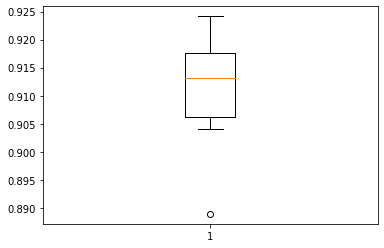

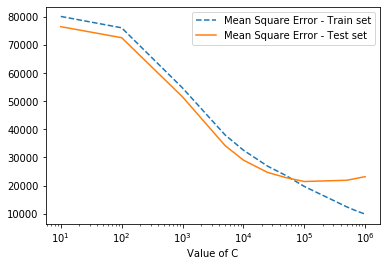

In [31]:
parameters = [1]
mse_report = np.zeros((len(parameters), n))
C = np.array([10, 100, 1000, 5000, 10000, 25000,50000,100000,500000,650000,800000,1000000])
MSETRAIN = np.empty([len(C)])
MSETEST = np.empty([len(C)])

for i, par in enumerate(parameters):
    for j in range(len(C)):
        reg = svm.SVR(kernel='rbf', gamma='scale', tol=0.0001, C=C[j], epsilon=0.0001)
        mse_report[i, :] = cross_val_score(reg, train_input, y_train, cv=cv)
        reg.fit(train_input, y_train)
        y_pred = reg.predict(test_input)
        y_pred_train = reg.predict(train_input)
        MSETRAIN[j] = sqrt(mean_squared_error(y_train, y_pred_train))
        MSETEST[j] = sqrt(mean_squared_error(y_test, y_pred))
        
        
plt.boxplot(mse_report.T)
mu_perf = np.mean(mse_report, axis=1)
std_perf = np.std(mse_report, axis=1)
max_perf = np.max(mse_report, axis=1)
min_perf = np.min(mse_report, axis=1)

reg.fit(train_input, y_train)
y_pred = reg.predict(test_input)
y_pred_train = reg.predict(train_input)


fig = plt.figure('Finding the minimum Mean Square error')

plt.plot(C,MSETRAIN, "--", label = 'Mean Square Error - Train set')
plt.plot(C,MSETEST, label = 'Mean Square Error - Test set')
plt.legend(loc = 'best')
plt.xlabel('Value of C')
ax = fig.add_subplot(111)
ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()

In [32]:
print("MSE train: ", MSETRAIN[-1])
print("r2 score train: ", r2_score(y_train, y_pred_train))

print("MSE test: ", MSETEST[-1])
print("r2 score test: ", r2_score(y_test, y_pred))

MSE train:  9851.153502261572
r2 score train:  0.9842139370435967
MSE test:  23145.382491914253
r2 score test:  0.9021044516181187


In [33]:
king_parameter = 10000
reg = svm.SVR(kernel='rbf', gamma='scale', tol=0.0001, C=king_parameter, epsilon=0.0001)
reg.fit(train_input, y_train)

n_opportunity = 280
results = prediction(x=test_input, reg=reg, n=len(test_input))
Opportunity_ranking_svm = results.sort_values(['Opportunity'], ascending=False,)
print(Opportunity_ranking_svm[:n_opportunity])

     Actual_Price  Prediction  Opportunity
102       82500.0    182362.0      99862.0
40        40000.0     96566.0      56566.0
223      121500.0    176852.0      55352.0
90        89471.0    136649.0      47178.0
246      165400.0    208362.0      42962.0
..            ...         ...          ...
206      367294.0    291454.0     -75840.0
69       335000.0    251504.0     -83496.0
9        378500.0    287143.0     -91357.0
133      394432.0    301162.0     -93270.0
234      415298.0    304165.0    -111133.0

[280 rows x 3 columns]


## K Closest Neighbors 

The number of neighbors K is the main hyperparameter to determine. The optimal K is found to be 3.

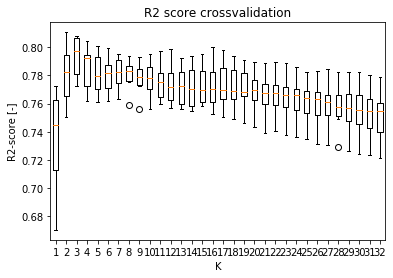

In [34]:
parameters = [i for i in range(1, 33)]
mse_report = np.zeros((len(parameters), n))
test_report = np.zeros((len(parameters), 2))

for i, par in enumerate(parameters):
        reg = KNeighborsRegressor(n_neighbors=par, n_jobs=-1)
        mse_report[i, :] = cross_val_score(reg, train_input, y_train, cv=cv)
        reg.fit(train_input, y_train)
        y_pred = reg.predict(train_input)
        test_report[i, 0] = mean_squared_error(y_train, y_pred)
        y_pred = reg.predict(test_input)
        test_report[i, 1] = mean_squared_error(y_test, y_pred)
        
        
        
plt.boxplot(mse_report.T)
plt.title('R2 score crossvalidation')
plt.xlabel('K')
plt.ylabel('R2-score [-]')
mu_perf = np.mean(mse_report, axis=1)
std_perf = np.std(mse_report, axis=1)
max_perf = np.max(mse_report, axis=1)
min_perf = np.min(mse_report, axis=1)

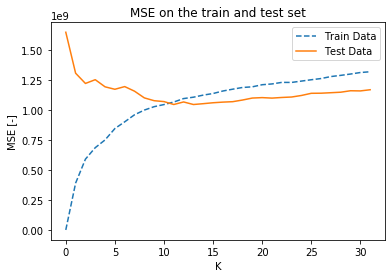

In [35]:
plt.plot(test_report[:, 0], "--", label = 'Train Data')
plt.plot(test_report[:, 1], label = 'Test Data')
plt.title('MSE on the train and test set')
plt.xlabel('K')
plt.ylabel('MSE [-]')
plt.legend()

In [36]:
king_parameter = 3
reg = KNeighborsRegressor(n_neighbors=king_parameter, n_jobs=-1)
print(train_input.shape)
reg.fit(train_input, y_train)
y_pred = reg.predict(test_input)
y_pred_train = reg.predict(train_input)

print("MSE train: ", sqrt(mean_squared_error(y_train, y_pred_train)))
print("r2 score train: ", r2_score(y_train, y_pred_train))

print("MSE test: ", sqrt(mean_squared_error(y_test, y_pred)))
print("r2 score test: ", r2_score(y_test, y_pred))

(1134, 81)
MSE train:  24275.84209411498
r2 score train:  0.9041376071091749
MSE test:  34925.76241499086
r2 score test:  0.7770918179743067


In [37]:
n_opportunity = 280
results = prediction(x=test_input, reg=reg, n=len(test_input))
Opportunity_ranking_neighbors = results.sort_values(['Opportunity'], ascending=False,)
print(Opportunity_ranking_neighbors[:n_opportunity])

     Actual_Price  Prediction  Opportunity
126      215000.0    339108.0     124108.0
102       82500.0    168333.0      85833.0
220      164000.0    248000.0      84000.0
40        40000.0    119500.0      79500.0
48       235000.0    314166.0      79166.0
..            ...         ...          ...
7        345000.0    268166.0     -76834.0
4        305900.0    221952.0     -83948.0
198      244400.0    160333.0     -84067.0
177      268000.0    181833.0     -86167.0
69       335000.0    215100.0    -119900.0

[280 rows x 3 columns]


## Random Forest 

In this section, the random forest model is used as regressor. The number of trees and the depth of the trees are the two hyper parameters that are optimized using the cross validation score. The boxplot representation demonstrates a small variation throughout the different settings. Therefore, the MSE and R2 score of each settings are calculated to have a better understanding on the impact of the hyperparameter settings.

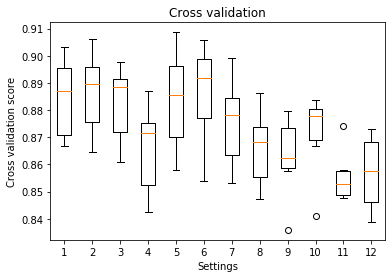

In [38]:
parameters = [(100, 50), (100, 20), (100, 7), (100, 5), (50, 50), (50, 20), (50, 7), (50, 5), 
              (10, 50), (10, 20), (10, 7), (10, 5)]

cross_val = np.zeros((len(parameters), n))
mse_report = np.zeros((2, (len(parameters))))
r2score_report = np.zeros((2, (len(parameters))))

for i, par in enumerate(parameters):
        reg = RandomForestRegressor(n_estimators=par[0], max_depth=par[1], max_features = 60)
        cross_val[i, :] = cross_val_score(reg, train_input, y_train, cv=cv)
        
        reg.fit(train_input, y_train)
        y_pred = reg.predict(test_input)
        y_pred_train = reg.predict(train_input)
                      
        mse_report[0, i] = sqrt(mean_squared_error(y_train, y_pred_train))
        r2score_report[0, i] = r2_score(y_train, y_pred_train)
        mse_report[1, i] = sqrt(mean_squared_error(y_test, y_pred))
        r2score_report[1, i] = r2_score(y_test, y_pred)
        
plt.boxplot(cross_val.T)
plt.title('Cross validation')
plt.ylabel('Cross validation score')
plt.xlabel('Settings')
mu_perf = np.mean(cross_val, axis=1)
std_perf = np.std(cross_val, axis=1)
max_perf = np.max(cross_val, axis=1)
min_perf = np.min(cross_val, axis=1)


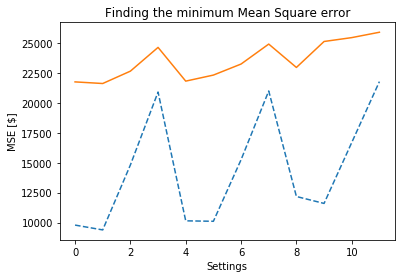

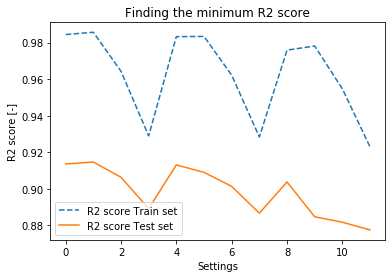

In [39]:
plt.plot(mse_report[0, :], "--", label = 'MSE Train set')
plt.plot(mse_report[1, :], label = 'MSE Test set')
plt.xlabel('Settings')
plt.ylabel('MSE [$]')
plt.title('Finding the minimum Mean Square error')

plt.figure()
plt.plot(r2score_report[0, :], "--", label = 'R2 score Train set')
plt.plot(r2score_report[1, :], label = 'R2 score Test set')
plt.xlabel('Settings')
plt.ylabel('R2 score [-]')
plt.title('Finding the minimum R2 score')
plt.legend()
plt.show()

The performances of the algorithm does not depend much on the number of trees that are grown as long as there are sufficient trees in the forest (in our case more than 10 seems to be enough). On the other side, the depth of the trees have a certain impact on the MSE and R2 scores. Above 7 partitionning, the algorithm tends to overfit the data with a R2 score of above 98%. However, the best performances on the test set are also obtained when the number of splitting is high. Therefore, the hyperparameters are set to 50 trees and 20 layers as a trade off between avoiding overfitting and having good performances.

<function matplotlib.pyplot.show(*args, **kw)>

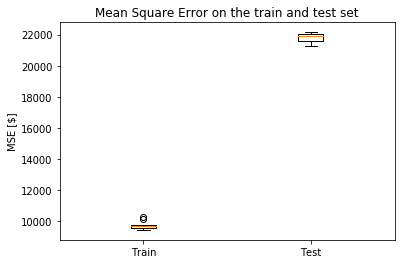

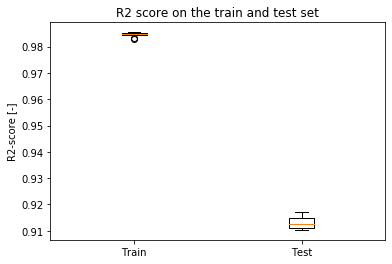

In [40]:
king_parameter = (50, 20)
mse_report = np.zeros((2, 10))
r2score_report = np.zeros((2, 10))

for i in range(10):
                              
        reg = RandomForestRegressor(n_estimators=king_parameter[0], max_depth=king_parameter[1], max_features = 50)
        reg.fit(train_input, y_train)
        y_pred = reg.predict(test_input)
        y_pred_train = reg.predict(train_input)
                      
        mse_report[0, i] = sqrt(mean_squared_error(y_train, y_pred_train))
        r2score_report[0, i] = r2_score(y_train, y_pred_train)
        mse_report[1, i] = sqrt(mean_squared_error(y_test, y_pred))
        r2score_report[1, i] = r2_score(y_test, y_pred)

        
        

plt.boxplot(mse_report.T)
plt.xticks(np.arange(1, 3), ['Train', 'Test'])
plt.title('Mean Square Error on the train and test set')
plt.ylabel('MSE [$]')

plt.figure()
plt.boxplot(r2score_report.T)
plt.xticks(np.arange(1, 3), ['Train', 'Test'])
plt.title('R2 score on the train and test set')
plt.ylabel('R2-score [-]')

plt.show

In [41]:
n_opportunity = 280
results = prediction(x=test_input, reg=reg, n=len(test_input))
Opportunity_ranking_forest = results.sort_values(['Opportunity'], ascending=False,)
print(Opportunity_ranking_forest[:n_opportunity])

     Actual_Price  Prediction  Opportunity
102       82500.0    173491.0      90991.0
23       315000.0    387453.0      72453.0
148      276000.0    337615.0      61615.0
40        40000.0    100615.0      60615.0
48       235000.0    294643.0      59643.0
..            ...         ...          ...
234      415298.0    371171.0     -44127.0
46       160000.0    115235.0     -44765.0
269      501837.0    455231.0     -46606.0
12       335000.0    286802.0     -48198.0
268      225000.0    169717.0     -55283.0

[280 rows x 3 columns]


## Neural Network

The hyperparameter to tune are related to the number of neural layers and the number of neuron per layer. 

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 75, 50, 25), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 1000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 66, 33), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 1000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
{'activation

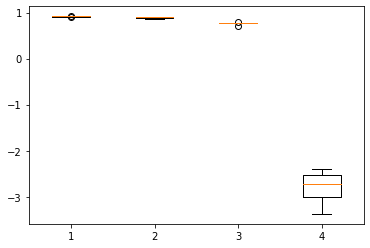

In [42]:
import warnings
warnings.filterwarnings('ignore')

parameters = [(100, 75, 50, 25), (100, 66, 33), (100, 50), (100,)]
mse_report = np.zeros((len(parameters), n))

for i, par in enumerate(parameters):
        reg = MLPRegressor(hidden_layer_sizes=par, activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10)
        print(reg.get_params())
        mse_report[i, :] = cross_val_score(reg, train_input, y_train, cv=cv)
        
plt.boxplot(mse_report.T)
mu_perf = np.mean(mse_report, axis=1)
std_perf = np.std(mse_report, axis=1)
max_perf = np.max(mse_report, axis=1)
min_perf = np.min(mse_report, axis=1)

In [43]:
king_parameter = (100,75,50,25)


for alpha in [5e-5,1e-4,1e-3]:
    for learning_rate in [5e-3,1e-3,1e-2,1e-1]:
        reg = MLPRegressor(hidden_layer_sizes=king_parameter, activation='relu', solver='adam', alpha=alpha, batch_size='auto', learning_rate='constant', learning_rate_init=learning_rate , power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.001, verbose=False, warm_start=False, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10)
        reg.fit(train_input, y_train)
        y_pred = reg.predict(test_input)
        y_pred_train = reg.predict(train_input)
        
        print('For Learning Rate init =',learning_rate , 'and alpha =', alpha,'gives r2 score of',r2_score(y_train, y_pred_train),'for train and of',r2_score(y_test, y_pred),'for test')



For Learning Rate init = 0.005 and alpha = 5e-05 gives r2 score of 0.9485666180908338 for train and of 0.9151096623937542 for test
For Learning Rate init = 0.001 and alpha = 5e-05 gives r2 score of 0.9462088167950518 for train and of 0.9144154562613188 for test
For Learning Rate init = 0.01 and alpha = 5e-05 gives r2 score of 0.9545213641698227 for train and of 0.8923536086809777 for test
For Learning Rate init = 0.1 and alpha = 5e-05 gives r2 score of 0.9490856416632711 for train and of 0.8984447953335558 for test
For Learning Rate init = 0.005 and alpha = 0.0001 gives r2 score of 0.94302092733107 for train and of 0.9157106408058633 for test
For Learning Rate init = 0.001 and alpha = 0.0001 gives r2 score of 0.9435014260434418 for train and of 0.9150024669088105 for test
For Learning Rate init = 0.01 and alpha = 0.0001 gives r2 score of 0.9554011512274847 for train and of 0.8965386931087231 for test
For Learning Rate init = 0.1 and alpha = 0.0001 gives r2 score of 0.9515413679725873 f

No significants improvements are found during the hyperparameters optimization

[0.91387781 0.91065764 0.90824928 0.90961774]


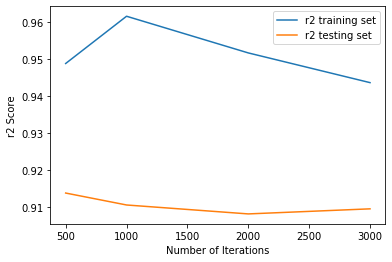

In [44]:
king_parameter = (100,75,50,25)
ite = [500,1000,2000,3000]

r2_train = []
r2_test = []

for iter in ite:
    reg = MLPRegressor(hidden_layer_sizes=king_parameter, activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.005, power_t=0.5, max_iter= iter , shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10)
    reg.fit(train_input, y_train)
    y_pred = reg.predict(test_input)
    y_pred_train = reg.predict(train_input)
    r2_train = np.append(r2_train,[r2_score(y_train, y_pred_train)])
    r2_test = np.append(r2_test,[r2_score(y_test, y_pred)]) 
    
plt.figure('r2 Score')
plt.plot(ite,r2_train, label = 'r2 training set')
plt.plot(ite,r2_test, label = 'r2 testing set')
plt.xlabel('Number of Iterations')
plt.ylabel('r2 Score')
plt.legend(loc = 'best')
plt.show

print(r2_test)

### Final Neural Network Chosen :


In [ ]:
king_parameter = (100,75,50,25)

mse_report = np.empty([6])

reg = MLPRegressor(hidden_layer_sizes=king_parameter, activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.005, power_t=0.5, max_iter= 2500 , shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10)
reg.fit(train_input, y_train)
y_pred = reg.predict(test_input)
y_pred_train = reg.predict(train_input)

MSEtrain = sqrt(mean_squared_error(y_train, y_pred_train))
MSEtest = sqrt(mean_squared_error(y_test, y_pred))

mse_report[:] = cross_val_score(reg, train_input, y_train, cv=cv)

plt.title('Cross Validation Scores')
plt.boxplot(mse_report.T)
plt.ylabel('Score')
mu_perf = np.mean(mse_report)
std_perf = np.std(mse_report)
max_perf = np.max(mse_report)
min_perf = np.min(mse_report)

print('MSEtrain :',sqrt(mean_squared_error(y_train, y_pred_train)))
print('r2score train :',r2_score(y_train, y_pred_train))
print('MSEtest:',sqrt(mean_squared_error(y_test, y_pred)))
print('r2 score test :',r2_score(y_test, y_pred))



In [ ]:
n_opportunity = 280
results = prediction(x=test_input, reg=reg, n=len(test_input))
Opportunity_ranking_neural = results.sort_values(['Opportunity'], ascending=False,)
print(Opportunity_ranking_neural[:n_opportunity])

# Business Analysis 

The algorithm with the best performances is the neural network one. It has a MSE of 22'000 and a R2 score of 91%. The performances on the train set are close to the one of the test set, demonstrating a relatively low chance of overfitting. Therefore, it is selected to estimate the possible profit on the houses.
  

The function prediction is built to compute the opportunity of each house. The opportunity represent the possible profit we could make by buying the house. Sorting the opportunity columns provide the houses with the best possible profit. The algorithm is mostly a refinement of the whole real estate market and a tool to assist the experts during the price setting. Indeed, several parameters are not taken into account in the algorithm such as macroeconomic variables. Moreover, as the information input comes from past data, the algorithm is not able to predict the price of a house in the medium to long term."

In [ ]:
Opportunity_ranking_svm['index'] = Opportunity_ranking_svm.index
Opportunity_ranking_neighbors['index'] = Opportunity_ranking_neighbors.index
Opportunity_ranking_forest['index'] = Opportunity_ranking_forest.index
Opportunity_ranking_neural['index'] = Opportunity_ranking_neural.index

Top_indexes = pd.DataFrame()
Top_indexes['SVM'] = Opportunity_ranking_svm['index'].values
Top_indexes['Neighbors'] = Opportunity_ranking_neighbors['index'].values
Top_indexes['Forest'] = Opportunity_ranking_forest['index'].values
Top_indexes['Neural'] = Opportunity_ranking_neural['index'].values
Top_indexes[:10]

In the last part of the algorithm, the dataframe with its original columns is reconstructed to provide the feature related to the most profitable houses. It will allow the experts to evaluate faster the relevance of the houses selection proposed.

In [ ]:
Data_tested = pd.DataFrame(X_test_in)

columns = list(columns_X_train)
columns = columns[:81]
Data_tested.columns = columns
Data_tested['SalePrice'] = y_test_in

In [ ]:
row = 39

Data_tested[row:row+1]

The price predictions for each regressor as well as the possible profit is given. The results from the regressor KNN strongly differs from the other regressors. Due to its higher MSE and lower R2-score, this regressor should not be accounted for the price prediction.

In [ ]:
prices_opportunity = Opportunity_ranking_svm.loc[Opportunity_ranking_svm['index'] == row]
prices_opportunity = prices_opportunity.append(Opportunity_ranking_neighbors.loc[Opportunity_ranking_svm['index'] == row])
prices_opportunity = prices_opportunity.append(Opportunity_ranking_forest.loc[Opportunity_ranking_svm['index'] == row])
prices_opportunity = prices_opportunity.append(Opportunity_ranking_neural.loc[Opportunity_ranking_svm['index'] == row])
prices_opportunity['Regressor'] = ['SVM','Closest_Neighbors','Random_Forest','Neural_Network']
prices_opportunity